# Clustering by DBSCAN

In [36]:
import numpy as np
from dvrl.dataset import EssayDataset

# Load essay data
print('Loading essay data...')
dataset = EssayDataset('../data/training_set_rel3.xlsx', '../data/hand_crafted_v3.csv', '../data/readability_features.csv')
dataset.preprocess_dataframe()
train_data, dev_data, test_data = dataset.cross_prompt_split(
    target_prompt_set=1,
    dev_size=30,
    cache_dir='.embedding_cache',
    embedding_model='bert-base-uncased',
    add_pos=False,
)
print(f'    Number of training samples: {len(train_data["essay_id"])}')
print(f'    Number of dev samples: {len(dev_data["essay_id"])}')
print(f'    Number of test samples: {len(test_data["essay_id"])}')

import umap

# Assign cluster based on embedding similarity
print('Assigning clusters based on embedding similarity...')
embeddings = train_data['embedding']

# UMAPで5次元に次元削減
reducer = umap.UMAP(n_components=5, random_state=42)
reduced_embeddings = reducer.fit_transform(embeddings)
# 埋め込みベクトルを正規化
norm_embeddings = reduced_embeddings / np.linalg.norm(reduced_embeddings, axis=1, keepdims=True)
# 得点データを結合
norm_embeddings = np.concatenate((norm_embeddings, train_data['scaled_score'].reshape(-1, 1)), axis=1)


from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering

# クラスタリング手法を選択
clustering_method = 'kmeans'  # 'dbscan', 'kmeans', 'agglomerative'

if clustering_method == 'dbscan':
    clustering = DBSCAN(eps=0.5, min_samples=2, metric='euclidean').fit(reduced_embeddings)
elif clustering_method == 'kmeans':
    clustering = KMeans(n_clusters=11194, random_state=42).fit(reduced_embeddings)  # n_clusters should be tuned
elif clustering_method == 'agglomerative':
    clustering = AgglomerativeClustering(n_clusters=5).fit(reduced_embeddings) # n_clusters should be tuned
else:
    raise ValueError("Invalid clustering method specified.")

train_data['cluster'] = clustering.labels_

print(f'    Number of training clusters: {len(np.unique(train_data["cluster"]))}')

Loading essay data...


0it [00:00, ?it/s]
0it [00:00, ?it/s]
/Users/takumishibata/Documents/project/DVRL-AES/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


    Number of training samples: 11194
    Number of dev samples: 30
    Number of test samples: 1753
Assigning clusters based on embedding similarity...
    Number of training clusters: 11194


In [38]:
clustering.labels_

array([ 6597,  6749,  2450, ..., 10543,  8438, 10725], dtype=int32)

In [37]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# t-SNEで次元削減
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(reduced_embeddings)

# クラスタリング結果をプロット
plt.figure(figsize=(12, 10))
for cluster in np.unique(train_data['cluster']):
    plt.scatter(embeddings_2d[train_data['cluster'] == cluster, 0], embeddings_2d[train_data['cluster'] == cluster, 1], label=cluster)
plt.legend()
plt.title('t-SNE Visualization of Essay Embeddings with DBSCAN Clustering')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

ValueError: Image size of 1029x234505 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1200x1000 with 1 Axes>

# EXP

In [2]:
from dvrl.predictor_config import MLPConfig, FeaturesModelConfig
MLPConfig.batch_size

512

In [193]:
import pickle
with open('/Users/takumishibata/Documents/project/DVRL-AES/data/allreadability.pickle', 'rb') as f:
    data = pickle.load(f)

In [194]:
import polars as pl
df = pl.DataFrame(data, schema_overrides={'column_0': pl.Int64})
df.rename({'column_0': 'item_id'}).write_csv('data/readability_features.csv')

In [200]:
pl.read_csv('data/hand_crafted_v3.csv').filter(pl.col('item_id') == 2979)

item_id,prompt_id,mean_word,word_var,mean_sent,sent_var,ess_char_len,word_count,prep_comma,unique_word,clause_per_s,mean_clause_l,max_clause_in_s,spelling_err,sent_ave_depth,ave_leaf_depth,automated_readability,linsear_write,stop_prop,positive_sentence_prop,negative_sentence_prop,neutral_sentence_prop,overall_positivity_score,overall_negativity_score,",",.,VB,JJR,WP,PRP$,VBN,VBG,IN,CC,JJS,PRP,MD,WRB,RB,VBD,RBR,VBZ,NNP,POS,WDT,DT,CD,NN,TO,JJ,VBP,RP,NNS,score
i64,i64,f64,f64,f64,f64,i64,i64,i64,i64,f64,f64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2979,2,3.886905,4.731257,56.0,882.666667,653,168,22,54,0.666667,3.5,1,15,8.666667,3.510638,25.3,28.0,0.434524,0.666667,0.0,0.333333,0.481833,0.0,0.027778,0.011111,0.088889,0.0,0.005556,0.027778,0.005556,0.005556,0.094444,0.011111,0.005556,0.038889,0.011111,0.033333,0.033333,0.0,0.0,0.027778,0.022222,0.0,0.011111,0.083333,0.0,0.144444,0.044444,0.088889,0.122222,0.0,0.038889,1.0


In [199]:
pl.read_csv('data/readability_features.csv').filter(pl.col('item_id') == 21633)

item_id,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31,column_32,column_33,column_34,column_35
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
21633,0.528986,0.442029,0.424033,0.523593,0.508228,0.438088,0.59555,0.318424,0.350352,0.422206,0.45385,0.415169,0.291667,0.302822,0.499235,0.532719,0.533784,0.475,0.291667,0.0,0.396648,0.380952,0.314465,0.333333,0.2,0.157143,0.325581,0.395683,0.2,0.1875,0.2,0.055556,0.454545,0.0,0.058824


# Clustering

In [1]:
import numpy as np
from utils.dataset import EssayDataset
from utils.create_embedding_feautres import feature_embedding

target_prompt_id = 4
dev_size = 30

print('Loading data...')
dataset = EssayDataset('data/training_set_rel3.xlsx', 'data/hand_crafted_v3.csv', 'data/readability_features.csv')
dataset.preprocess_dataframe()
train_data, dev_data, test_data = dataset.cross_prompt_split(target_prompt_set=target_prompt_id, dev_size=dev_size)
train_data['simple_embedding'] = feature_embedding(train_data['essay'])
dev_data['simple_embedding'] = feature_embedding(dev_data['essay'])
test_data['simple_embedding'] = feature_embedding(test_data['essay'])
train_data['ridley_feature'] = np.concatenate([train_data['feature'], train_data['readability']], axis=1)
dev_data['ridley_feature'] = np.concatenate([dev_data['feature'], dev_data['readability']], axis=1)
test_data['ridley_feature'] = np.concatenate([test_data['feature'], test_data['readability']], axis=1)
cluster_assignments, cluster_centroids = dataset.clustering(train_data['ridley_feature'], np.array(train_data['essay_set']), np.array(train_data['original_score']))

/Users/takumishibata/.pyenv/versions/3.12.0/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading data...


/Users/takumishibata/.pyenv/versions/3.12.0/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
0it [00:00, ?it/s]
0it [00:00, ?it/s]


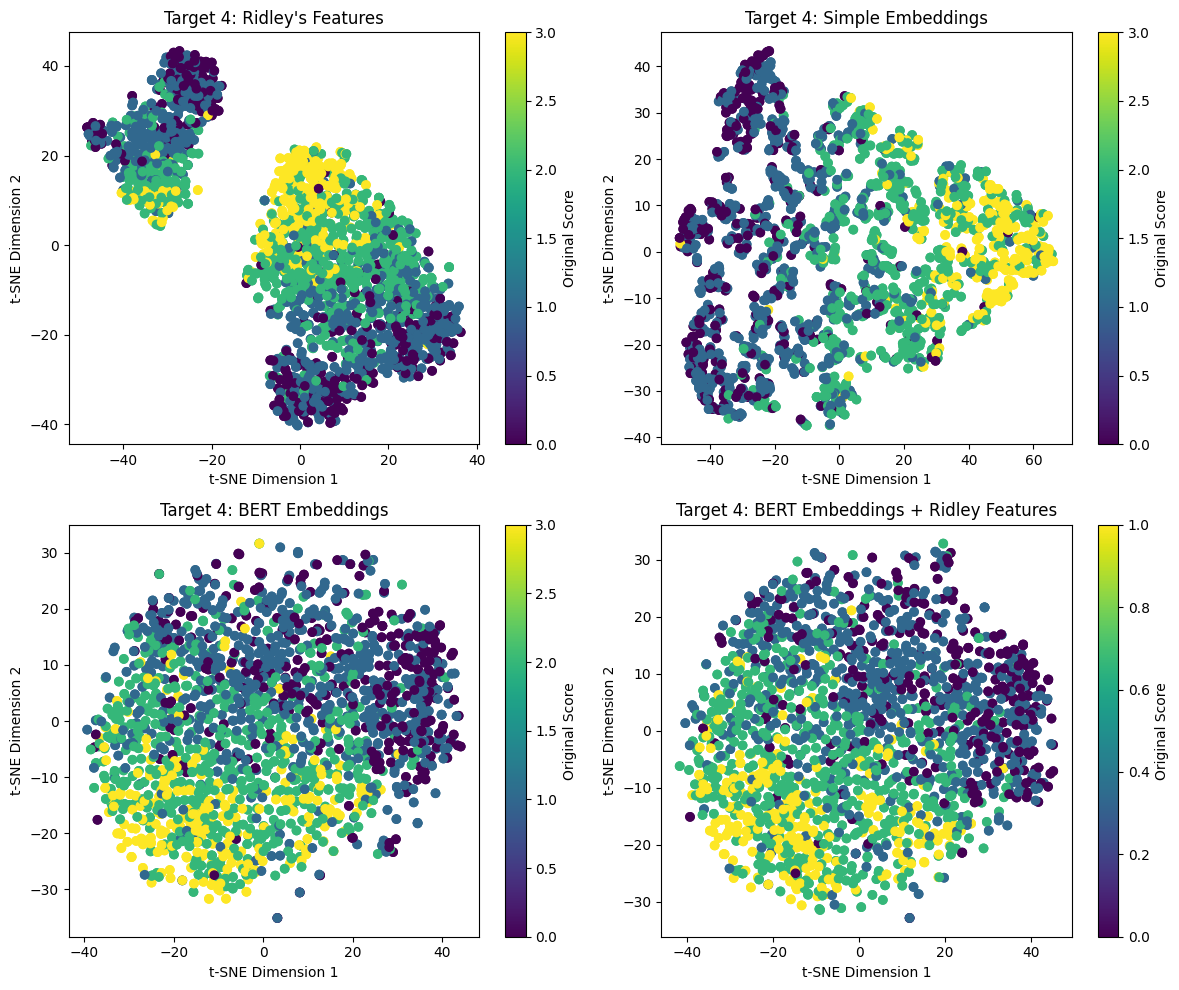

In [5]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

features = test_data['ridley_feature']
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(features)

axes[0, 0].scatter(tsne_result[:, 0], tsne_result[:, 1], c=test_data['original_score'], cmap='viridis')
axes[0, 0].set_xlabel('t-SNE Dimension 1')
axes[0, 0].set_ylabel('t-SNE Dimension 2')
axes[0, 0].set_title(f"Target {target_prompt_id}: Ridley's Features")
# Add a colorbar to the plot
plt.colorbar(axes[0, 0].scatter(tsne_result[:, 0], tsne_result[:, 1], c=test_data['original_score'], cmap='viridis'), label='Original Score', ax=axes[0, 0])

features = test_data['simple_embedding']
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(features)

axes[0, 1].scatter(tsne_result[:, 0], tsne_result[:, 1], c=test_data['original_score'], cmap='viridis')
axes[0, 1].set_xlabel('t-SNE Dimension 1')
axes[0, 1].set_ylabel('t-SNE Dimension 2')
axes[0, 1].set_title(f'Target {target_prompt_id}: Simple Embeddings')
# Add a colorbar to the plot
plt.colorbar(axes[0, 1].scatter(tsne_result[:, 0], tsne_result[:, 1], c=test_data['original_score'], cmap='viridis'), label='Original Score', ax=axes[0, 1])

features = test_data['embedding']
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(features)

axes[1, 0].scatter(tsne_result[:, 0], tsne_result[:, 1], c=test_data['original_score'], cmap='viridis')
axes[1, 0].set_xlabel('t-SNE Dimension 1')
axes[1, 0].set_ylabel('t-SNE Dimension 2')
axes[1, 0].set_title(f'Target {target_prompt_id}: BERT Embeddings')
# Add a colorbar to the plot
plt.colorbar(axes[1, 0].scatter(tsne_result[:, 0], tsne_result[:, 1], c=test_data['original_score'], cmap='viridis'), label='Original Score', ax=axes[1, 0])

features = np.concatenate([test_data['ridley_feature'], test_data['embedding']], axis=1)
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(features)

axes[1, 1].scatter(tsne_result[:, 0], tsne_result[:, 1], c=test_data['scaled_score'], cmap='viridis')
axes[1, 1].set_xlabel('t-SNE Dimension 1')
axes[1, 1].set_ylabel('t-SNE Dimension 2')
axes[1, 1].set_title(f'Target {target_prompt_id}: BERT Embeddings + Ridley Features')
# Add a colorbar to the plot
plt.colorbar(axes[1, 1].scatter(tsne_result[:, 0], tsne_result[:, 1], c=test_data['scaled_score'], cmap='viridis'), label='Original Score', ax=axes[1, 1])

plt.tight_layout()
plt.show()

# Prompt data

In [1]:
import polars as pl
pl.read_csv('data/prompts.csv')

essay_set,prompt
i64,str
1,"""More and more people use compu…"
2,"""Censorship in the Libraries ""A…"
3,"""Write a response that explains…"
4,"""Read the last paragraph of the…"
5,"""Describe the mood created by t…"
6,"""Based on the excerpt, describe…"
7,"""Write about patience. Being pa…"
8,"""We all understand the benefits…"


In [2]:
score_ranges = {
    1: {'min': 2, 'max': 12},
    2: {'min': 1, 'max': 6},
    3: {'min': 0, 'max': 3},
    4: {'min': 0, 'max': 3},
    5: {'min': 0, 'max': 4},
    6: {'min': 0, 'max': 4},
    7: {'min': 0, 'max': 30},
    8: {'min': 0, 'max': 60},
}

In [4]:
prompts = []
scores = []
for key, min_max_range in score_ranges.items():
    minscore = min_max_range['min']
    maxscore = min_max_range['max']
    for i in range(minscore, maxscore + 1):
        prompts.append(key)
        scores.append(i)

In [33]:
# essay_set 7,8以外は(essay_set, score)の組み合わせごとにクラスタ番号を振る
# essay_set 7,8は5点刻みでグループ化してからクラスタ番号を振る
df = pl.DataFrame({'essay_set': prompts, 'score': scores})

# essay_set 7,8のscoreを5点刻みでグループ化
df = df.with_columns(
    pl.when(pl.col('essay_set').is_in([7, 8]))
    .then((pl.col('score') / 5).cast(pl.Int64) * 5) # Use integer division and cast to integer
    .otherwise(pl.col('score'))
    .alias('score_group')
)

# クラスタ番号を振る
df = df.with_columns(
    pl.struct(['essay_set', 'score_group'])
    .map_elements(lambda x: f"{x['essay_set']:02d}{x['score_group']:03d}", return_dtype=pl.String)
    .cast(pl.Int64)
    .rank('dense')
    .alias('cluster')
)

# 元のscoreを戻してpromptと結合
df = df.drop('score_group').join(pl.read_csv('data/prompts.csv'), on='essay_set', how='left')
df

essay_set,score,cluster,prompt
i64,i64,u32,str
1,2,1,"""More and more people use compu…"
1,3,2,"""More and more people use compu…"
1,4,3,"""More and more people use compu…"
1,5,4,"""More and more people use compu…"
1,6,5,"""More and more people use compu…"
…,…,…,…
8,56,54,"""We all understand the benefits…"
8,57,54,"""We all understand the benefits…"
8,58,54,"""We all understand the benefits…"


In [47]:
df

essay_set,score,cluster,prompt
i64,i64,u32,str
1,2,1,"""More and more people use compu…"
1,3,2,"""More and more people use compu…"
1,4,3,"""More and more people use compu…"
1,5,4,"""More and more people use compu…"
1,6,5,"""More and more people use compu…"
…,…,…,…
8,56,54,"""We all understand the benefits…"
8,57,54,"""We all understand the benefits…"
8,58,54,"""We all understand the benefits…"


In [1]:
from dvrl.prompt_dataset import PromptDataset

/Users/takumishibata/.pyenv/versions/3.12.0/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = PromptDataset('data/prompts.csv')

/Users/takumishibata/.pyenv/versions/3.12.0/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/Users/takumishibata/.pyenv/versions/3.12.0/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [3]:
dataset = data.load()

In [4]:
dataset

{'essay_set': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4,
        4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]),
 'score': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,
         0,  1,  2,  3,  0,  1,  2,  3,  0,  1,  2,  3,  4,  0,  1,  2,  3,
         4,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,  0,  1,
         2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
        53, 54,

In [42]:
import polars as pl
df = pl.read_csv(f'../outputs/dvrl_v4/estimated_values_1_mlp_seed12_cluster10000.csv')

In [45]:
df.select(pl.quantile('values', 0.1))

values
f64
0.298848


In [55]:
df.quantile(0.1, 'nearest')['values'].item()

0.29884765